In [14]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from mgnn.MolGraphNetwork import MolGraphNetwork
from utils import find_repo_root
from scf_guess_tools import Backend
from scf_guess_datasets import Qm9

project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)
BASIS_PATH = "../../../scripts/6-31g_2df_p_custom_nwchem.gbs"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Project root directory: /home/etschgi1/REPOS/Masterarbeit
Using device: cpu


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sys.path.append('../src/')
sys.path.append("../../scripts/")
from plt_config import use_latex, TU_GREY, TU_RED
use_latex()
sns.set_palette(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [16]:
local_pc_path = os.path.join(project_root_dir, "datasets/QM9") if str(device) != "cuda" else "/home/dmilacher/datasets/data1"
dataset = Qm9(
    local_pc_path, 
    size = 500, # number of molecules to load
    # val=0.1, # using 80% training / 10 % val / 10% test split
    # test=0.1
)


In [17]:
train_n = [dataset.molecule(x).natm for x in dataset.train_keys]
val_n = [dataset.molecule(x).natm for x in dataset.val_keys]
test_n = [dataset.molecule(x).natm for x in dataset.test_keys]

In [18]:
rows = []
for n in train_n: 
    rows.append({"natm": n, "set": "train"})
for n in val_n:
    rows.append({"natm": n, "set": "val"})
for n in test_n:
    rows.append({"natm": n, "set": "test"})
data = pd.DataFrame(rows)
savepath = os.path.join(project_root_dir, "latex/fig/application/strat_sample.pdf")

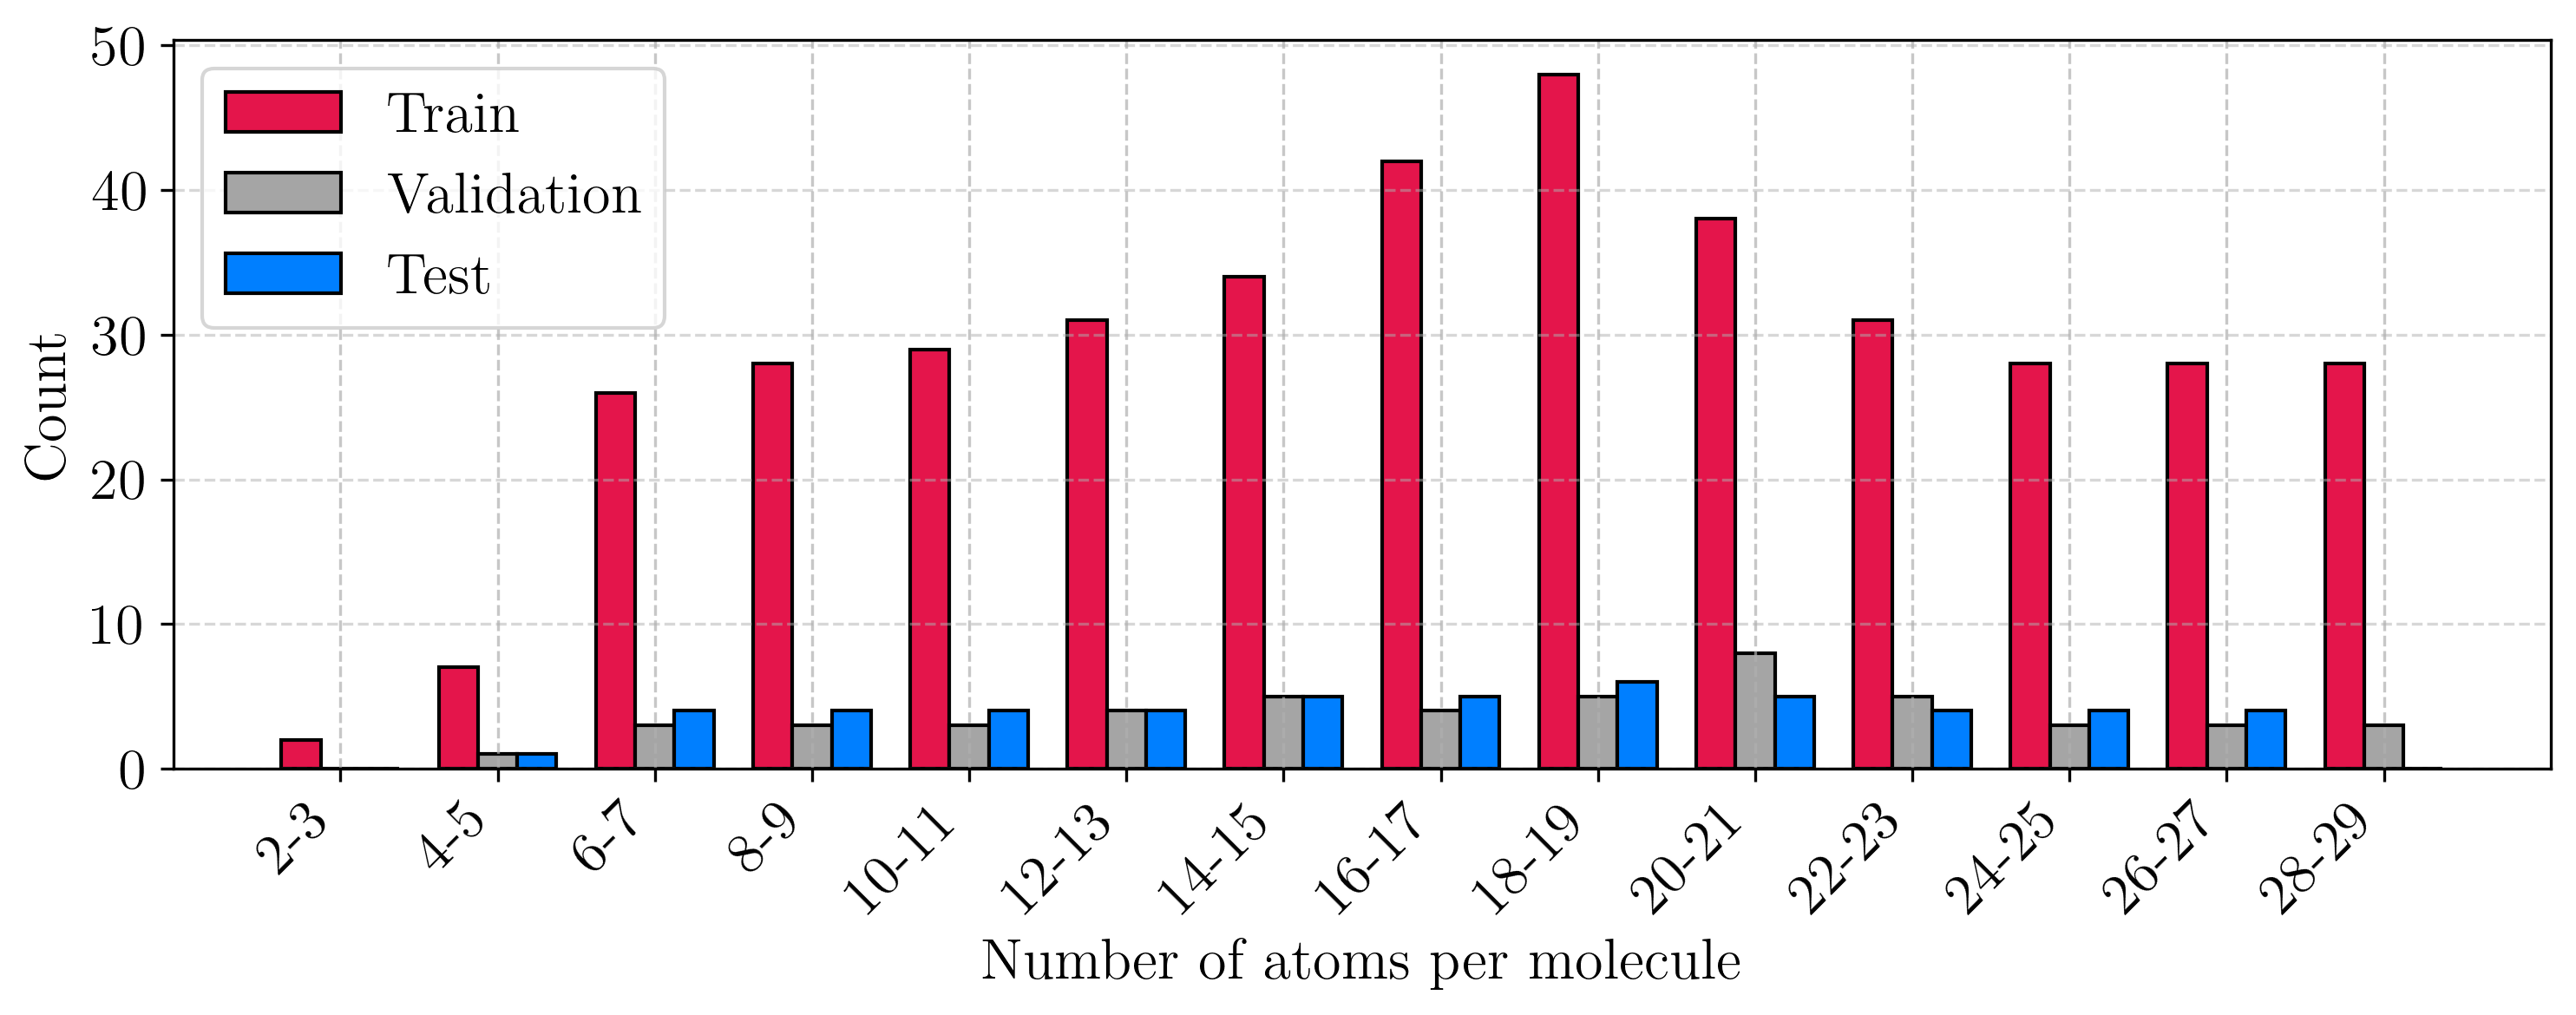

In [34]:
df = pd.DataFrame({
    "natm": train_n + val_n + test_n,
    "set": ["Train"]      * len(train_n)
          + ["Validation"]* len(val_n)
          + ["Test"]      * len(test_n)
})


bin_width = 2
min_atm, max_atm = df["natm"].min(), df["natm"].max()
edges = np.arange(min_atm-1, max_atm + bin_width, bin_width)
labels = [f"{int(edges[i])}-{int(edges[i+1]-1)}" for i in range(len(edges)-1)]
bin_centers = (edges[:-1] + edges[1:]) / 2


df["natm_bin"] = pd.cut(
    df["natm"],
    bins=edges,
    labels=labels,
    include_lowest=True,
    right=False  # [left, right)
)
groups = ["Train", "Validation", "Test"]
counts = {g: df[df["set"] == g]["natm_bin"].value_counts().reindex(labels, fill_value=0)
          for g in groups}


plt.figure(figsize=(10, 4))

bar_width = 0.5
offsets = [-bar_width, 0, +bar_width] 

for off, g in zip(offsets, groups):
    plt.bar(bin_centers + off,
            counts[g].values,
            width=bar_width,
            label=g,
            edgecolor="black")

plt.xticks(bin_centers, labels, rotation=45, ha="right")
plt.xlabel("Number of atoms per molecule")
plt.ylabel("Count")
plt.legend(title="", loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(savepath)
plt.show()
